# Introduction

Machine learning has a phenomenal range of applications, including in health and diagnostics. This tutorial will explain the complete pipeline from loading data to predicting results, and it will explain how to build an Breast Cancer image classification model from scratch to predict whether an image shows presence of malignant cancer.

**Follow the steps to download data from Kaggle 1st time**

Login in Kaggle and download the kaggle.json File from Kaggle settings.
**(One Time Activity)**

Click on the folder icon on left menu bar and upload the kaggle.json file.

In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download paultimothymooney/breast-histopathology-images

Mount the Google Drive to move the downloaded zip file to google drive so that we don't have to download all the time

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Create a folder as per mentioned below directory
***Colab Notebooks/Breast_Cancer_Classification/dataset***
Post that move the file using the below code

In [ ]:
mv '/content/breast-histopathology-images.zip' 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/dataset/'

 ---------------------------------------------------------------------

**Follow the below steps if you have the data zip file downloaded from kaggle in your gdrive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
mkdir /content/dataset/

In [3]:
mkdir /content/dataset/initialPath

In [4]:
mkdir /content/dataset/finalPath

In [5]:
! unzip "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/dataset/breast-histopathology-images" -d /content/dataset/initialPath

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1551_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1601_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1651_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1701_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1751_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1801_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1851_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1901_class0.png  
  inflating: /content/dataset/initialPath/IDC_regular_ps50_idx5/9346/0/9346_idx5_x2351_y1951_class0.p

In [6]:
mkdir /content/output

In [7]:
mkdir /content/utils

In [8]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/config.py' '/content/utils/config.py'

In [9]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/conv_bc_model.py' '/content/utils/conv_bc_model.py'

In [10]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/create_dataset.py' '/content/utils/create_dataset.py'

In [11]:
cp 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/utils/getPaths.py' '/content/utils/getPaths.py'

Running the Build Dataset file to shuffle and create the train test val folders and files

In [12]:
! python /content/utils/create_dataset.py

555048
555048
Making 'training' split
'Creating /content/dataset/finalPath/training' directory
'creating /content/dataset/finalPath/training/0' directory
'creating /content/dataset/finalPath/training/1' directory
Making 'validation' split
'Creating /content/dataset/finalPath/validation' directory
'creating /content/dataset/finalPath/validation/0' directory
'creating /content/dataset/finalPath/validation/1' directory
Making 'testing' split
'Creating /content/dataset/finalPath/testing' directory
'creating /content/dataset/finalPath/testing/0' directory
'creating /content/dataset/finalPath/testing/1' directory


-------------------------------------------------------------------------------

## Model Building and Evaluation

In [ ]:
# Mounting the google drive
# from google.colab import drive
# drive.mount('/content/gdrive')

In [ ]:
# Google Drive Path
# gDrivePath = "gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/"

In [ ]:
# import sys
# sys.path.append(gDrivePath)

In [13]:
# Setting the matplotlib backend so that if required then images can be saved in the background
import matplotlib
matplotlib.use("Agg")
%matplotlib inline

In [14]:
# Importing the libraries
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
from tensorflow.keras.optimizers import Adam
from utils import config
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import cv2

In [ ]:
# pip install seaborn

In [15]:
# Defining a function for plotting the count of data against each class in each directory
def plotData(dirPath):
    # Get the path to the benign and malignant sub-directories
    benign_cases_dir = dirPath+ '/0/'
    malignant_cases_dir = dirPath + '/1/'

    # Get the list of all the images
    benign_cases = glob.glob(benign_cases_dir + '*.png')
    malignant_cases = glob.glob(malignant_cases_dir + '*.png')

    # An empty list. We will insert the data into this list in (img_path, label) format
    data1 = []

    # Go through all the benign cases. The label for these cases will be 0
    for img in benign_cases:
        data1.append((img,0))

    # Go through all the malignant cases. The label for these cases will be 1
    for img in malignant_cases:
        data1.append((img, 1))

    # Get a pandas dataframe from the data we have in our list 
    data1 = pd.DataFrame(data1, columns=['image', 'label'],index=None)

    # Shuffle the data 
    data1 = data1.sample(frac=1.).reset_index(drop=True)
    
    
    
    # Get the counts for each class
    cases_count = data1['label'].value_counts()
    print(cases_count)

    # Plot the results 
    plt.figure(figsize=(10,8))
    sns.barplot(x=cases_count.index, y= cases_count.values)
    plt.title('Number of cases', fontsize=14)
    plt.xlabel('Case type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(range(len(cases_count.index)), ['benign(0)', 'malignant(1)'])
    plt.show()

0    183235
1     72627
Name: label, dtype: int64


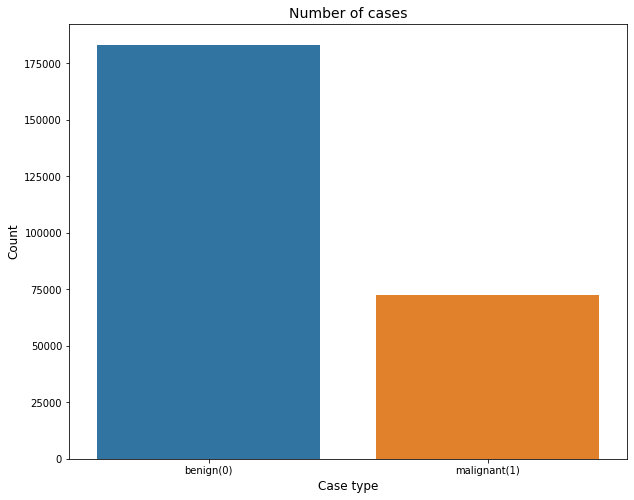

In [16]:
plotData(config.TRAIN_PATH)

0    71433
1    28496
Name: label, dtype: int64


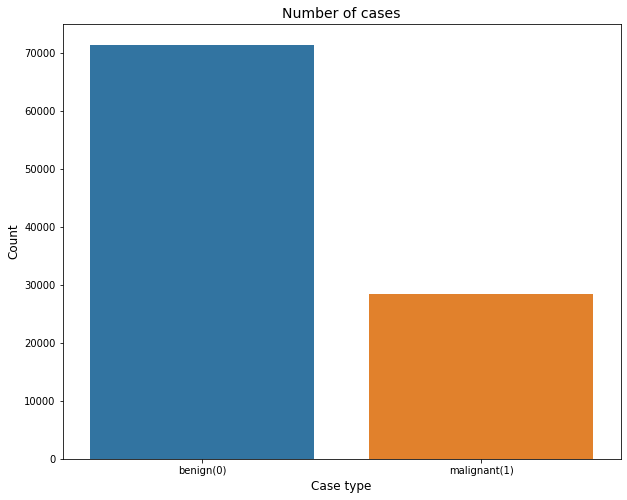

In [17]:
plotData(config.TEST_PATH)

0    30611
1    12067
Name: label, dtype: int64


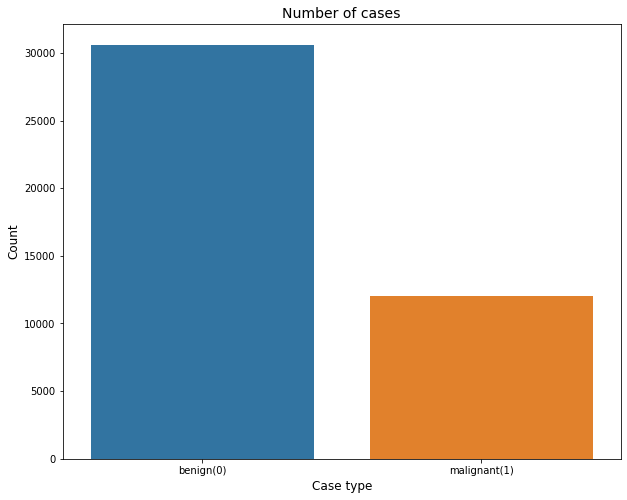

In [18]:
plotData(config.VAL_PATH)

In [19]:
# Get the path to the benign and malignant sub-directories
benign_cases_dir = config.TRAIN_PATH + '/0/'
malignant_cases_dir = config.TRAIN_PATH + '/1/'

# Get the list of all the images
benign_cases = glob.glob(benign_cases_dir + '*.png')
malignant_cases = glob.glob(malignant_cases_dir + '*.png')

# An empty list. We will insert the data into this list in (img_path, label) format
train_data1 = []

# Go through all the benign cases. The label for these cases will be 0
for img in benign_cases:
    train_data1.append((img,0))

# Go through all the malignant cases. The label for these cases will be 1
for img in malignant_cases:
    train_data1.append((img, 1))

# Get a pandas dataframe from the data we have in our list 
train_data1 = pd.DataFrame(train_data1, columns=['image', 'label'],index=None)

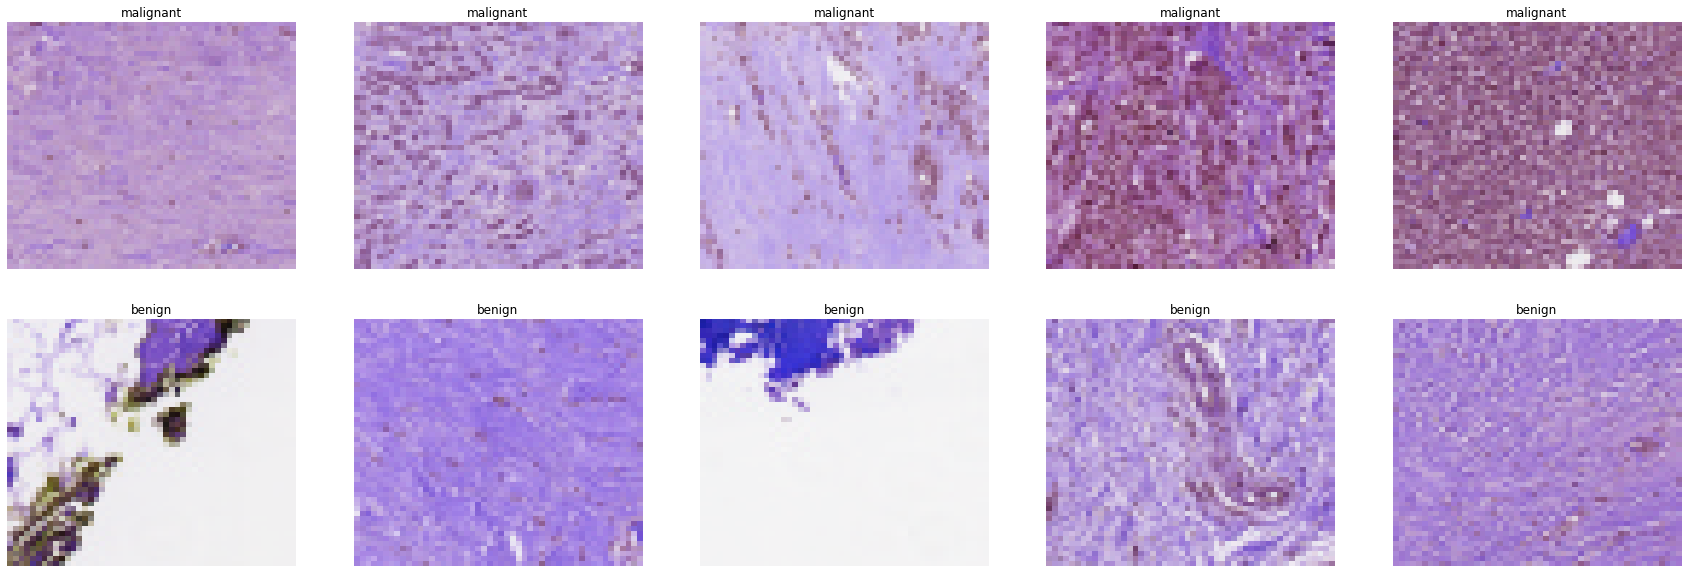

In [20]:
# Get few samples for both the classes
malignant_samples = (train_data1[train_data1['label']==1]['image'].iloc[:5]).tolist()
benign_samples = (train_data1[train_data1['label']==0]['image'].iloc[:5]).tolist()

# Concat the data in a single list and del the above two list
samples = malignant_samples + benign_samples
del malignant_samples, benign_samples

# Plot the data 
f, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(10):
    img = cv2.imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    if i<5:
        ax[i//5, i%5].set_title("malignant")
    else:
        ax[i//5, i%5].set_title("benign")
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
plt.show()

If we look carefully, then there are some cases where we won't be able to differentiate between a benign case and a malignant case with the naked eye. If we can build a robust classifier, it would be a great assist for the doctor too.

In [21]:
# Defining a method to get the number of files given a path
def retrieveNumberOfFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return len(list1)

In [22]:
# Defining a method to plot training and validation accuracy and loss
def training_plot(H, N, plotPath):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    plt.savefig(plotPath)

In [23]:
# Checking for the total number of image paths in training, validation and testing directories
totalTrain = retrieveNumberOfFiles(config.TRAIN_PATH)
totalVal = retrieveNumberOfFiles(config.VAL_PATH)
totalTest = retrieveNumberOfFiles(config.TEST_PATH)

In [24]:
# Defining a method to get the number of files given a path
def getAllFiles(path):
    list1 = []
    for file_name in glob.iglob(path+'/**/*.png', recursive=True):
        list1.append(file_name)
    return list1

In [25]:
# Retrieving all files from train directory
allTrainFiles = getAllFiles(config.TRAIN_PATH)

In [26]:
# Calculating the total number of training images against each class and then store the class weights in a dictionary
trainLabels = [int(p.split(os.path.sep)[-2]) for p in allTrainFiles]
trainLabels = to_categorical(trainLabels)
classSumTotals = trainLabels.sum(axis=0)
classWeight = dict()

# Looping over all classes and calculate the class weights
for i in range(0, len(classSumTotals)):
    classWeight[i] = classSumTotals.max() / classSumTotals[i]

In [27]:
# Initialize the training data augmentation object
## preprocess_input will scale input pixels between -1 and 1
## rotation_range is a value in degrees (0-180), a range within which to randomly rotate pictures
## zoom_range is for randomly zooming inside pictures
## width_shift and height_shift are ranges (as a fraction of total width or height) within which to randomly translate pictures vertically or horizontally
## shear_range is for randomly applying shearing transformations
## horizontal_flip and vertical_flip is for randomly flipping half of the images horizontally and vertically resp
## fill_mode is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift

trainAug = ImageDataGenerator(
	preprocessing_function=preprocess_input,
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	vertical_flip=True,
	fill_mode="nearest")

In [28]:
# Initialize the validation data augmentation object
valAug = ImageDataGenerator(preprocessing_function=preprocess_input)

In [29]:
# As per the preprocessing step
# defining the ImageNet mean subtraction in RGB order and setting the 
# mean subtraction values for each of the data augmentation objects

# mean = np.array([123.68, 116.779, 103.939], dtype="float32")
# trainAug.mean = mean
# valAug.mean = mean

In [30]:
# Initialize the training generator
trainGen = trainAug.flow_from_directory(
	config.TRAIN_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=True,
	batch_size=config.BATCH_SIZE)

Found 255862 images belonging to 2 classes.


In [31]:
# Initialize the validation generator
valGen = valAug.flow_from_directory(
	config.VAL_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 42678 images belonging to 2 classes.


In [32]:
# Initialize the testing generator
testGen = valAug.flow_from_directory(
	config.TEST_PATH,
	class_mode="categorical",
	target_size=(48, 48),
	color_mode="rgb",
	shuffle=False,
	batch_size=config.BATCH_SIZE)

Found 99929 images belonging to 2 classes.


In [33]:
# Loading the ResNet50, ensuring the head Full Connected layers are left off / removed
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(48, 48, 3)))

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
# Printing the baseModel layers after removing the head
baseModel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 54, 54, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 24, 24, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 24, 24, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [34]:
# Construct the head of the model that will be placed on top of the the base model
## Flattening is converting the data into a 1-dimensional array for inputting it to the next layer. 
## We flatten the output of the convolutional layers to create a single long feature vector. 
### Average pooling computes the average of the elements present in the region of feature map covered by the filter.
#### ReLU stands for Rectified Linear Unit. 
#### The main advantage of using the ReLU function over other activation functions is that it does not activate all the neurons at the same time.
## Dropout is a technique where randomly selected neurons are ignored during training.

headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7), padding="same")(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(config.CLASSES), activation="softmax")(headModel)

In [35]:
# Placing the head model on top of the base model
model = Model(inputs=baseModel.input, outputs=headModel)

In [36]:
# Loop over all the layers of the base model and freeze them so that they are 
# not updated during the training process
for layer in baseModel.layers:
    layer.trainable = False

In [37]:
# Printing all the layers of the model to check whether the baseModel layers are changed to not trainable
for layer in model.layers:
    print("{}: {}".format(layer, layer.trainable))

<keras.engine.input_layer.InputLayer object at 0x7f0f303fdc50>: False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0f32473c10>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0f304b6110>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0f318ca550>: False
<keras.layers.core.activation.Activation object at 0x7f0f2fdf4690>: False
<keras.layers.reshaping.zero_padding2d.ZeroPadding2D object at 0x7f0f25f7f0d0>: False
<keras.layers.pooling.max_pooling2d.MaxPooling2D object at 0x7f0f25fac910>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0f303fd5d0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0f25f42150>: False
<keras.layers.core.activation.Activation object at 0x7f0f25f39190>: False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f0f25f35bd0>: False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f0f25f54710>: False
<ke

In [38]:
# Compiling the model
## Decay updates the learning rate by a decreasing factor in each epoch
print("Compiling model")
opt = Adam(lr=config.INIT_LR, decay=config.INIT_LR / config.EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [39]:
# Using ModelCheckpoint to store the best performing model based on val_loss
MCName = os.path.sep.join([config.outputPath, "weights-{epoch:03d}-{val_loss:.4f}.hdf5"])
checkpoint = ModelCheckpoint(MCName, monitor="val_loss", mode="min", save_best_only=True, verbose=1)
callbacks = [checkpoint]

In [40]:
# Fitting the model on training data
print("Model Fitting")
MF = model.fit(
    x=trainGen,
    steps_per_epoch=totalTrain // config.BATCH_SIZE,
    validation_data=valGen,
    validation_steps=totalVal // config.BATCH_SIZE,
    class_weight=classWeight,
    callbacks=callbacks,
    epochs=config.EPOCHS)

Model Fitting
Epoch 1/20
7995/7995 [==============================] - ETA: 0s - loss: 0.6506 - accuracy: 0.8018
Epoch 1: val_loss improved from inf to 0.50059, saving model to /content/output/weights-001-0.5006.hdf5
7995/7995 [==============================] - 606s 74ms/step - loss: 0.6506 - accuracy: 0.8018 - val_loss: 0.5006 - val_accuracy: 0.7588
Epoch 2/20
7995/7995 [==============================] - ETA: 0s - loss: 0.5956 - accuracy: 0.8172
Epoch 2: val_loss improved from 0.50059 to 0.42849, saving model to /content/output/weights-002-0.4285.hdf5
7995/7995 [==============================] - 472s 59ms/step - loss: 0.5956 - accuracy: 0.8172 - val_loss: 0.4285 - val_accuracy: 0.8090
Epoch 3/20
7995/7995 [==============================] - ETA: 0s - loss: 0.5869 - accuracy: 0.8202
Epoch 3: val_loss did not improve from 0.42849
7995/7995 [==============================] - 430s 54ms/step - loss: 0.5869 - accuracy: 0.8202 - val_loss: 0.4484 - val_accuracy: 0.7995
Epoch 4/20
7995/7995 [===

In [41]:
# Loading the best performing model
# Please specify the model name from the output folder which has the lowest val_loss
path1 = config.outputPath + '/weights-009-0.3958.hdf5'
fModel = load_model(path1)

In [43]:
# Predicting on the test data
print("Predicting on the test data")
predTest = fModel.predict(x=testGen, steps=(totalTest // config.BATCH_SIZE)+1)
predTest = np.argmax(predTest, axis=1)

Predicting on the test data
3123/3123 [==============================] - 112s 36ms/step


In [44]:
# Printing the Classification Report
print(classification_report(testGen.classes, predTest, target_names=testGen.class_indices.keys()))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87     71433
           1       0.64      0.85      0.73     28496

    accuracy                           0.82     99929
   macro avg       0.79      0.83      0.80     99929
weighted avg       0.85      0.82      0.83     99929



In [45]:
# Computing the confusion matrix and and using the same to derive the 
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testGen.classes, predTest)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# Printing the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[58022 13411]
 [ 4179 24317]]
acc: 0.8240
sensitivity: 0.8123
specificity: 0.8533


In [46]:
# Calculate roc auc
XGB_roc_value = roc_auc_score(testGen.classes, predTest)
print("XGboost roc_value: {0}" .format(XGB_roc_value))

XGboost roc_value: 0.8328027391597062


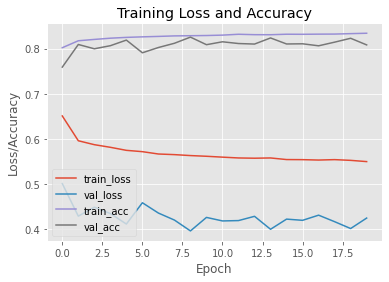

In [47]:
# Plotting the graph
training_plot(MF, config.EPOCHS, config.PLOT_PATH)

In [ ]:
# Serialize/Writing the model to disk
print("Serializing network...")
fModel.save(config.MODEL_PATH, save_format="h5")

Serializing network...


In [48]:
cp '/content/output/weights-009-0.3958.hdf5' 'gdrive/MyDrive/Colab Notebooks/Breast_Cancer_Classification/output'